In [1]:
import sys
sys.path.append('..')
sys.path = [ '/home/etsymbalov/.local/lib/python3.6/site-packages'] + sys.path

In [2]:
import torch
seed = 8715
torch.manual_seed(seed)
import numpy as np
np.random.seed(seed)

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm

from experiment_setup import get_model, set_random, build_estimator
from uncertainty_estimator.masks import build_masks 
from dataloader.toy import ToyQubicData, ToySinData
from model.mlp import MLP

plt.rcParams['figure.facecolor'] = 'white'
from dataloader.builder import build_dataset
from model.mlp import MLP
from uncertainty_estimator.masks import build_masks 
from experiment_setup import build_estimator
from analysis.metrics import get_uq_metrics
from experiments.utils.data import scale, split_ood, multiple_kfold

In [4]:
config = {
    'nn_runs': 100,
    'runs': 2,
    'max_runs': 20,
    'k_folds': 10,
    'verbose': False,
    # Our train config
   'layers': [8, 128, 128, 256, 1],
#     'layers': [8, 256, 256, 128, 1],
    #'layers': [8, 2048, 2048, 1024, 1],
    'epochs': 10_000,
    'validation_step': 100,
    
    # Our train config
    'nll_layers': [8, 256, 256, 128, 2],
    'nll_epochs': 400,
    'nll_validation_step': 50,
    
    'acc_percentile': 0.1,
    'patience': 10,
    'dropout_rate': 0.5,
    'dropout_uq': 0.5,
    'batch_size': 256,
    'dataset': 'kin8nm',
    'l2_reg': 1e-5,
    'ood_percentile': 90,
    'activation': 'celu',
    'optimizer': {'type': 'Adam', 'lr': 0.01, 'weight_decay':1e-5}
}

In [5]:
xs = []
ys = []

xs_sector = []
ys_sector = []
for _ in range(2000):
    q = np.random.random()*100 % 2*np.pi       
    
    r = 1 + np.random.random()*.4 - .2
    
    x = np.sin(q)*r
    y = np.cos(q)*r
    if 1.1 < q < 2.1:
        xs_sector.append(x)
        ys_sector.append(y)
    else:
        xs.append(x)
        ys.append(y)

In [6]:
xs[:4]

[0.27381922029284594,
 -0.3657399660877054,
 -0.03902800668196427,
 -0.9797088308165596]

In [7]:
xs_inner_ood = []
ys_inner_ood = []

xs_outer_ood = []
ys_outer_ood = []
for _ in range(1000):
    q = np.random.random()*100 % 2*np.pi       
    
    r = 2 + np.random.random()*.5 - .25
    x = np.sin(q)*r
    y = np.cos(q)*r
    xs_outer_ood.append(x)
    ys_outer_ood.append(y)

    r = .3 + np.random.random()*.2 - .1
    x = np.sin(q)*r
    y = np.cos(q)*r
    xs_inner_ood.append(x)
    ys_inner_ood.append(y)

In [8]:
xs_inner_ood[:4]

[-0.2335485568662339,
 0.2825976119349189,
 -0.04914702440940038,
 -0.01938899566843634]

In [9]:
def f(x, y):
    return np.cos(np.sin(x*y) +
                  np.sin(x + y) + 
                  x - y + 
                  np.abs(x*np.cos(y)) * np.exp(np.sign(y)*np.sqrt(np.abs(y))))

In [10]:
xcc = []
ycc = []
for xc, yc in [(xs, ys), 
               (xs_sector, ys_sector),
               (xs_outer_ood, xs_outer_ood),
               (xs_inner_ood, ys_inner_ood),
              ]:
    xq = []
    fs = []
    for cnt in range(len(xc)):
        x = xc[cnt]; y = yc[cnt]
        fs.append(f(x, y))
        xq.append((x, y))
    xq = np.array(xq)
    fs = np.array(fs)[:, None]
    xcc.append(xq)
    ycc.append(fs)
x_train_, x_sect, x_outer, x_inner   = xcc
y_train_, y_sect, y_outer, y_inner   = ycc
x_train = x_train_[:1200]
y_train = y_train_[:1200]
x_val = x_train_[1200:]
y_val = y_train_[1200:]

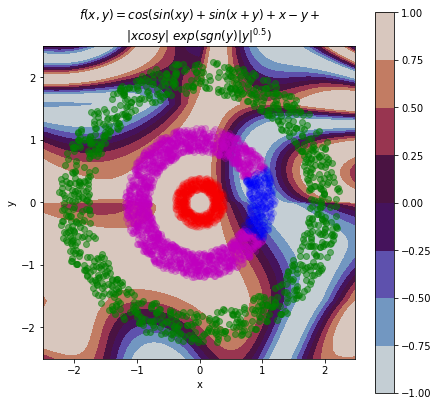

In [11]:
plt.figure(figsize=(7,7))

y = np.arange(-2.5, 2.5, 0.01)
xx, yy = np.meshgrid(y, y, sparse=True)
z = f(xx, yy)
h = plt.contourf(y,y,z, cmap=cm.twilight)

plt.plot(xs, ys, 'mo',
         alpha = .25)
plt.plot(xs_sector, ys_sector, 'bo', alpha = .15
        )

plt.plot(xs_outer_ood, ys_outer_ood, 'go',
         alpha = .5
        )
plt.plot(xs_inner_ood, ys_inner_ood, 'ro',
         alpha = .1
        )
plt.colorbar()
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')
# p.cos(np.sin(x*y) +
#                   np.sin(x + y) + 
#                   x - y + 
# #                   np.abs(x*np.cos(y)) * np.exp(np.sign(y)*np.sqrt(np.abs(y))))
plt.title(r'$f(x,y) = cos(sin(x y) + sin(x + y) + x - y +$' + '\n' + r'$|x cos y|~exp(sgn(y) |y|^{0.5})$')

plt.savefig('./images/2d_toy.png', dpi = 300)

In [12]:
import torch.nn.functional as F

In [13]:
config['layers'][0] = x_train.shape[-1]
masks = build_masks(nn_runs=config['nn_runs'])
model = MLP(config['layers'], 
            l2_reg=config['l2_reg'],
            activation = F.celu
           )
train_opts = ['patience', 'dropout_rate', 'epochs', 
              'batch_size', 'validation_step']
train_config = {k: config[k] for k in config if k in train_opts}
model.fit((x_train, y_train), (x_val, y_val), **train_config)

Epoch [100/10000], Loss: 0.0312, Validation loss: 0.0245
Epoch [200/10000], Loss: 0.0271, Validation loss: 0.0254
Epoch [300/10000], Loss: 0.0316, Validation loss: 0.0181
Epoch [400/10000], Loss: 0.0243, Validation loss: 0.0229
Epoch [500/10000], Loss: 0.0265, Validation loss: 0.0315
Epoch [600/10000], Loss: 0.0153, Validation loss: 0.0114
Epoch [700/10000], Loss: 0.0256, Validation loss: 0.0146
Epoch [800/10000], Loss: 0.0199, Validation loss: 0.0155
Epoch [900/10000], Loss: 0.0218, Validation loss: 0.0132
Epoch [1000/10000], Loss: 0.0156, Validation loss: 0.0140
Epoch [1100/10000], Loss: 0.0177, Validation loss: 0.0115
Epoch [1200/10000], Loss: 0.0267, Validation loss: 0.0230
Epoch [1300/10000], Loss: 0.0411, Validation loss: 0.0172
Epoch [1400/10000], Loss: 0.0341, Validation loss: 0.0111
Epoch [1500/10000], Loss: 0.0133, Validation loss: 0.0072
Epoch [1600/10000], Loss: 0.0158, Validation loss: 0.0105
Epoch [1700/10000], Loss: 0.0158, Validation loss: 0.0137
Epoch [1800/10000], Los

In [14]:
paper_names = {
    'basic_bern': 'MC dropout',
    'decorrelating_sc': 'decorrelation',
    'dpp': 'dpp',
    'k_dpp': 'k_dpp',
    'k_dpp_noisereg': 'k_dpp_noisereg',
    'ideal': 'ideal'
}

In [15]:
lrg_test = []
xxss = np.arange(-10, 10, .05)
for xq in xxss:
    for yq in xxss:
        lrg_test.append([xq, yq])
lrg_test = np.array(lrg_test)

basic_bern
decorrelating
decorrelating_sc
dpp
k_dpp
k_dpp_noisereg


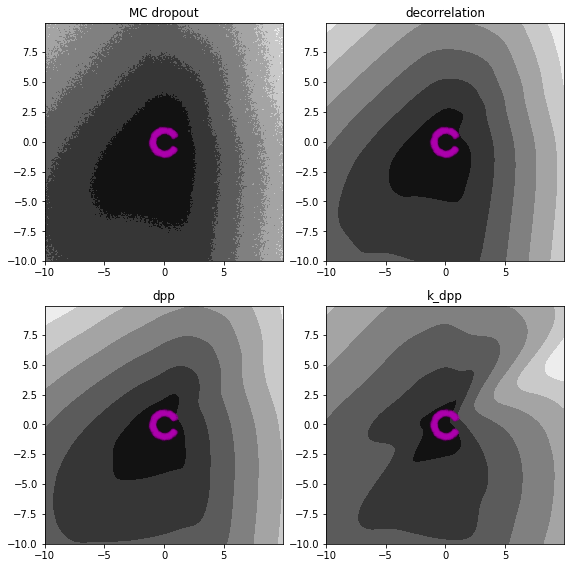

In [16]:
cnt = 0
ests = {}
plt.figure(figsize=(8,8))
au = ['basic_bern', 'decorrelating_sc', 'dpp', 'k_dpp']
for name, mask in masks.items():
    print(name)
    if name not in au:
        continue
    
    cnt += 1
    
    if hasattr(mask, 'reset'):
        mask.reset()
    estimator = build_estimator(
        'mcdue_masked', model, 
        nn_runs=config['nn_runs'],
        dropout_mask=mask,
        dropout_rate=config['dropout_uq'])
    estimations = estimator.estimate(lrg_test)
    ests[name] = estimations
    estimations = estimations/max(np.ravel(estimations))
    
    
    plt.subplot(2,2,cnt)
    plt.contourf(xxss,
             xxss,
             estimations.reshape((len(xxss), len(xxss))).T,
             cmap=cm.gray, #levels = 20
            )
    plt.axis('square')
    plt.plot(xs, ys, 'm.',
             alpha = .05)
    plt.title(paper_names[name])
plt.tight_layout()
# plt.savefig('./images/dpp_ring_contour.png', dpi = 600)

In [17]:
estimations[:4]

array([0.36644775, 0.36625873, 0.36609953, 0.36597234])

In [18]:
np.sum(estimations)

67206.65753848039

In [19]:
dss = [np.array([xs, ys]).T, 
       np.array([xs_sector, ys_sector]).T, 
       np.array([xs_outer_ood, ys_outer_ood]).T, 
       np.array([xs_inner_ood, ys_inner_ood]).T, 
      ]
labels = ['val', 'sector', 'outer', 'inner']

ues2 = {}
for name, mask in masks.items():
    local_dct = {}
    if hasattr(mask, 'reset'):
        mask.reset()
    for dataset, label in zip(dss, labels):
        print(name, label)
        
        estimator = build_estimator(
            'mcdue_masked', model,
            nn_runs=config['nn_runs'],
            dropout_mask=mask,
            dropout_rate=config['dropout_uq'])
        
        local_dct[label] = estimator.estimate(dataset)
    ues2[name] = local_dct

basic_bern val
basic_bern sector
basic_bern outer
basic_bern inner
decorrelating val
decorrelating sector
decorrelating outer
decorrelating inner
decorrelating_sc val
decorrelating_sc sector
decorrelating_sc outer
decorrelating_sc inner
dpp val
dpp sector
dpp outer
dpp inner
k_dpp val
k_dpp sector
k_dpp outer
k_dpp inner
k_dpp_noisereg val
k_dpp_noisereg sector
k_dpp_noisereg outer
k_dpp_noisereg inner


In [20]:
import pandas as pd
import seaborn as sns
name = 'ideal'
local_dct = {}
for dataset, label in zip(dss, labels):
    ans_true = np.ravel(f(dataset[:,0],dataset[:,1]))
    prediction = np.ravel(model(dataset).cpu().numpy())
    local_dct[label] = np.abs(ans_true - prediction)
ues2[name] = local_dct

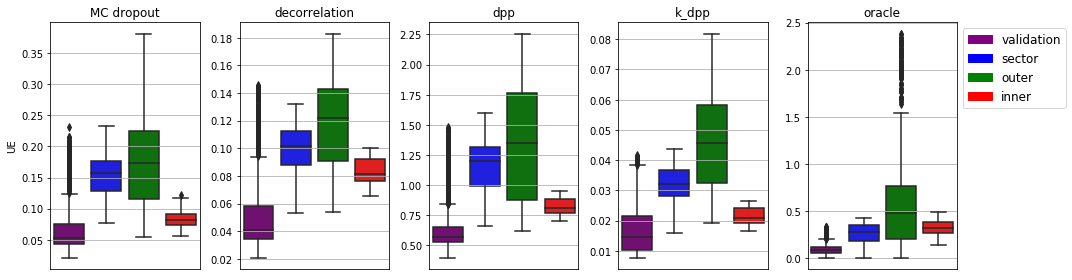

In [21]:
plt.figure(figsize=(15, 4))
cnt = 0
paper_names = {
    'basic_bern': 'MC dropout',
    'decorrelating_sc': 'decorrelation',
    'dpp': 'dpp',
    'k_dpp': 'k_dpp',
    'k_dpp_noisereg': 'k_dpp_noisereg',
    'ideal': 'oracle'
}
my_pal = {"val": "purple", "sector": "b", "outer":"g", "inner":"r"}
for name in ['basic_bern', 'decorrelating_sc', 'dpp', 
             'k_dpp', 'ideal']:
    data = []
    cnt += 1
    for key, vals in ues2[name].items():
        for val in vals:
            data.append([val, key])
    dfq = pd.DataFrame(data, columns = ['UE', 'split'])
    plt.subplot(1,5,cnt)
    bplot = sns.boxplot(y = dfq['UE'], x = dfq['split'], palette = my_pal)
#     bplot = sns.violinplot(y = dfq['UE'], x = dfq['split'], palette = my_pal)
    plt.grid()
    plt.title(paper_names[name])
    plt.xlabel('')
    if cnt > 1:
        plt.ylabel('')
    plt.xticks([])

#     for i in range(4):
#         mybox = bplot.artists[i]
#         mybox.set_facecolor('mbgr'[i])
        
import matplotlib.patches as mpatches
plt.legend(handles=[mpatches.Patch(color='purple', label='validation'),
                    mpatches.Patch(color='blue', label='sector'),
                    mpatches.Patch(color='green', label='outer'),
                    mpatches.Patch(color='red', label='inner')
                   ], bbox_to_anchor=(1,1), fontsize=12)
# plt.legend(['validation', 'sector', 'outer', 'inner'])
plt.tight_layout()
# plt.savefig('./images/ring_results.png', dpi = 600)

In [22]:
dfq.head()

,UE,split
0,0.089391,val
1,0.066970,val
2,0.111389,val
3,0.006460,val
4,0.135842,val
